# Task 8: Traffic Sign Recognition

## Objective
Classify traffic signs based on their image using deep learning

## Dataset
GTSRB Dataset (Simulated for demonstration)

## Tasks:
1. Preprocess images (resizing, normalization)
2. Train a CNN model to recognize different traffic sign classes
3. Evaluate performance using accuracy and confusion matrix
4. Bonus: Add data augmentation to improve performance
5. Bonus: Compare custom CNN vs. pre-trained model (e.g., MobileNet)

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Check GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

In [4]:
# Create synthetic traffic sign dataset
np.random.seed(42)
n_samples = 2000
img_size = 64

# Traffic sign classes
sign_classes = [
    'Speed Limit 20', 'Speed Limit 30', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70',
    'Speed Limit 80', 'End of Speed Limit 80', 'Speed Limit 100', 'Speed Limit 120',
    'No Passing', 'No Passing for Vehicles over 3.5 Metric Tons',
    'Right-of-Way at Next Intersection', 'Priority Road', 'Yield', 'Stop',
    'No Vehicles', 'Vehicles over 3.5 Metric Tons Prohibited', 'No Entry',
    'General Caution', 'Dangerous Curve Left', 'Dangerous Curve Right',
    'Double Curve', 'Bumpy Road', 'Slippery Road', 'Road Narrows on Right',
    'Road Work', 'Traffic Signals', 'Pedestrians', 'Children Crossing',
    'Bicycles Crossing', 'Beware of Ice/Snow', 'Wild Animals Crossing',
    'End of All Speed and Passing Limits', 'Turn Right Ahead', 'Turn Left Ahead',
    'Ahead Only', 'Go Straight or Right', 'Go Straight or Left', 'Keep Right',
    'Keep Left', 'Roundabout Mandatory', 'End of No Passing', 'End of No Passing by Vehicles over 3.5 Metric Tons'
]

print(f"Number of traffic sign classes: {len(sign_classes)}")
print(f"Sample classes: {sign_classes[:10]}")

# Generate synthetic images and labels
images = []
labels = []

for i in range(n_samples):
    # Randomly select a class
    class_idx = np.random.randint(0, len(sign_classes))
    
    # Create synthetic image based on class characteristics
    img = np.zeros((img_size, img_size, 3))
    
    # Different patterns for different sign types
    if 'Speed Limit' in sign_classes[class_idx]:
        # Red circle with white number
        cv2.circle(img, (img_size//2, img_size//2), img_size//3, (255, 0, 0), -1)
        cv2.circle(img, (img_size//2, img_size//2), img_size//3-5, (255, 255, 255), -1)
        # Add number
        number = sign_classes[class_idx].split()[-1]
        cv2.putText(img, number, (img_size//2-10, img_size//2+5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
    elif 'Stop' in sign_classes[class_idx]:
        # Red octagon
        points = np.array([[img_size//2, img_size//4], [3*img_size//4, img_size//4],
                          [7*img_size//8, img_size//2], [3*img_size//4, 3*img_size//4],
                          [img_size//2, 7*img_size//8], [img_size//4, 3*img_size//4],
                          [img_size//8, img_size//2], [img_size//4, img_size//4]], dtype=np.int32)
        cv2.fillPoly(img, [points], (255, 0, 0))
        cv2.putText(img, 'STOP', (img_size//2-20, img_size//2+5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    elif 'Yield' in sign_classes[class_idx]:
        # Red triangle
        points = np.array([[img_size//2, img_size//4], [img_size//4, 3*img_size//4],
                          [3*img_size//4, 3*img_size//4]], dtype=np.int32)
        cv2.fillPoly(img, [points], (255, 255, 0))
        cv2.putText(img, 'YIELD', (img_size//2-20, img_size//2+5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 2)
    elif 'No Entry' in sign_classes[class_idx]:
        # Red circle with white bar
        cv2.circle(img, (img_size//2, img_size//2), img_size//3, (255, 0, 0), -1)
        cv2.rectangle(img, (img_size//4, img_size//2-5), (3*img_size//4, img_size//2+5), (255, 255, 255), -1)
    else:
        # Generic warning sign (yellow triangle)
        points = np.array([[img_size//2, img_size//4], [img_size//4, 3*img_size//4],
                          [3*img_size//4, 3*img_size//4]], dtype=np.int32)
        cv2.fillPoly(img, [points], (0, 255, 255))
        cv2.putText(img, '!', (img_size//2-5, img_size//2+5), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    
    # Add noise and variations
    noise = np.random.normal(0, 10, img.shape)
    img = np.clip(img + noise, 0, 255).astype(np.uint8)
    
    # Add rotation and scaling variations
    angle = np.random.uniform(-15, 15)
    scale = np.random.uniform(0.8, 1.2)
    
    # Apply transformations
    M = cv2.getRotationMatrix2D((img_size//2, img_size//2), angle, scale)
    img = cv2.warpAffine(img, M, (img_size, img_size))
    
    images.append(img)
    labels.append(class_idx)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Image size: {X[0].shape}")
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution:")
unique, counts = np.unique(y, return_counts=True)
for i, (class_idx, count) in enumerate(zip(unique, counts)):
    print(f"  {sign_classes[class_idx]}: {count}")

Number of traffic sign classes: 43
Sample classes: ['Speed Limit 20', 'Speed Limit 30', 'Speed Limit 50', 'Speed Limit 60', 'Speed Limit 70', 'Speed Limit 80', 'End of Speed Limit 80', 'Speed Limit 100', 'Speed Limit 120', 'No Passing']
Dataset shape: (2000, 64, 64, 3)
Labels shape: (2000,)
Image size: (64, 64, 3)
Number of classes: 43
Class distribution:
  Speed Limit 20: 51
  Speed Limit 30: 45
  Speed Limit 50: 55
  Speed Limit 60: 34
  Speed Limit 70: 46
  Speed Limit 80: 40
  End of Speed Limit 80: 43
  Speed Limit 100: 36
  Speed Limit 120: 43
  No Passing: 41
  No Passing for Vehicles over 3.5 Metric Tons: 51
  Right-of-Way at Next Intersection: 48
  Priority Road: 32
  Yield: 45
  Stop: 45
  No Vehicles: 52
  Vehicles over 3.5 Metric Tons Prohibited: 48
  No Entry: 48
  General Caution: 59
  Dangerous Curve Left: 49
  Dangerous Curve Right: 47
  Double Curve: 42
  Bumpy Road: 44
  Slippery Road: 44
  Road Narrows on Right: 50
  Road Work: 46
  Traffic Signals: 46
  Pedestrians:

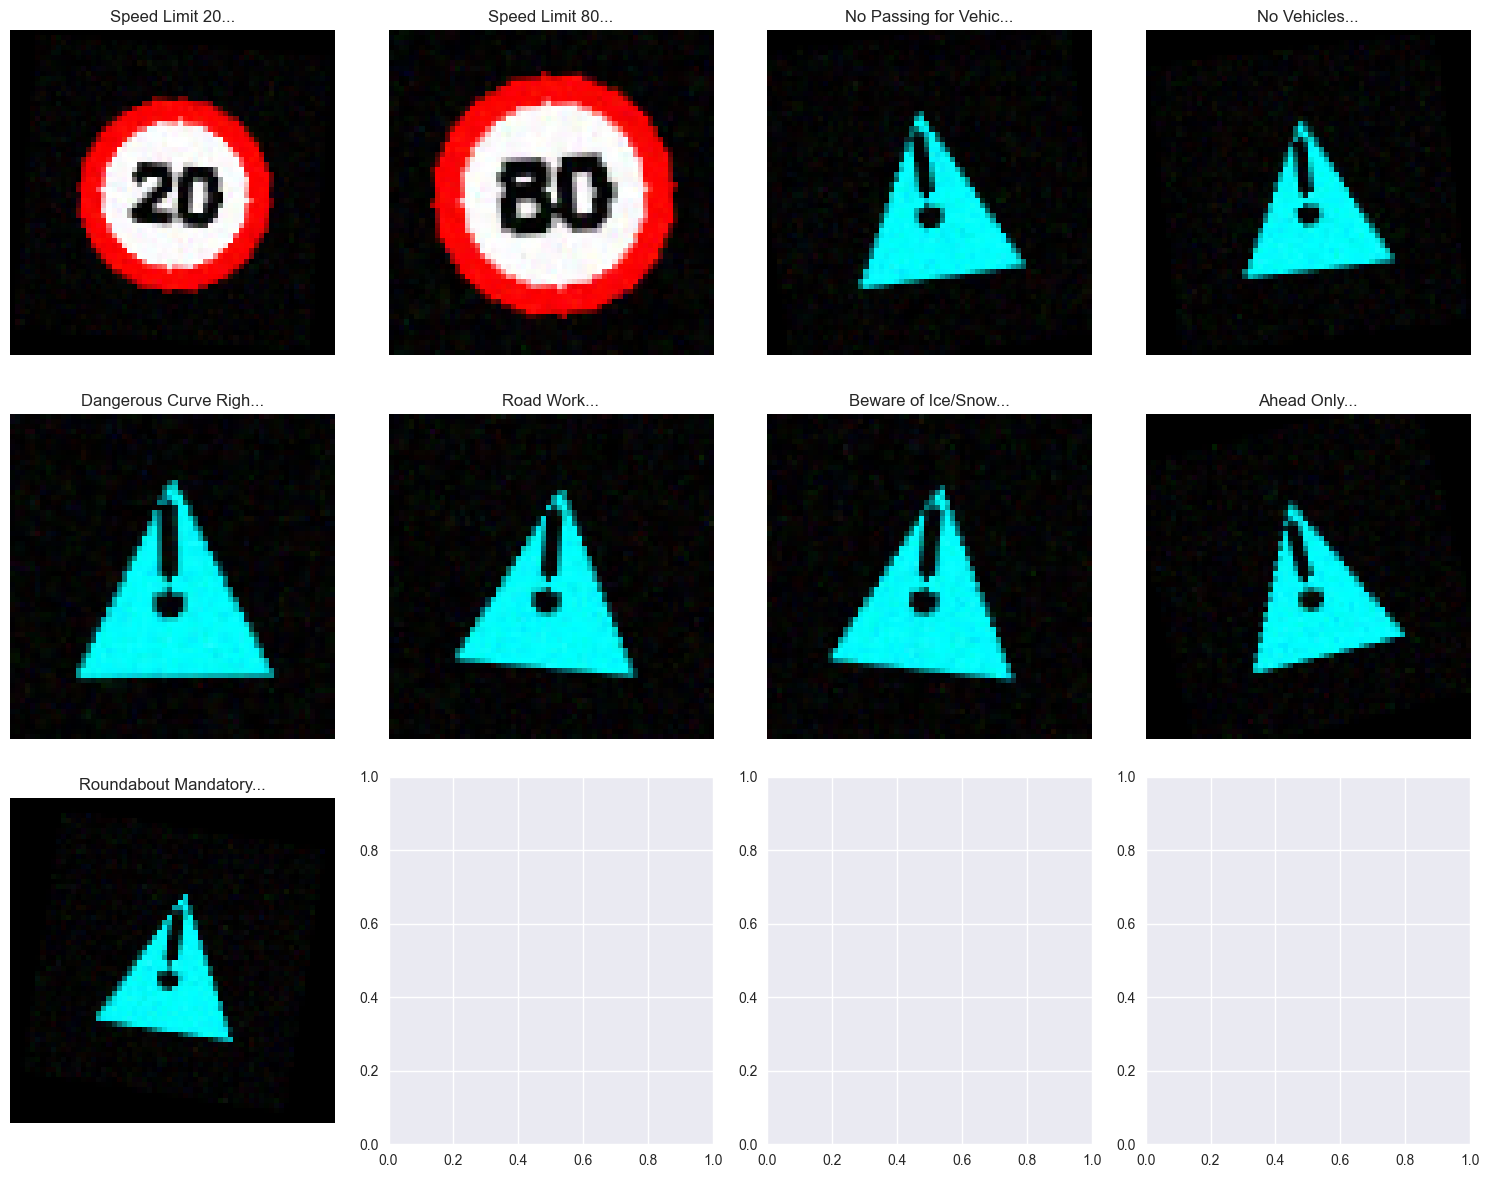

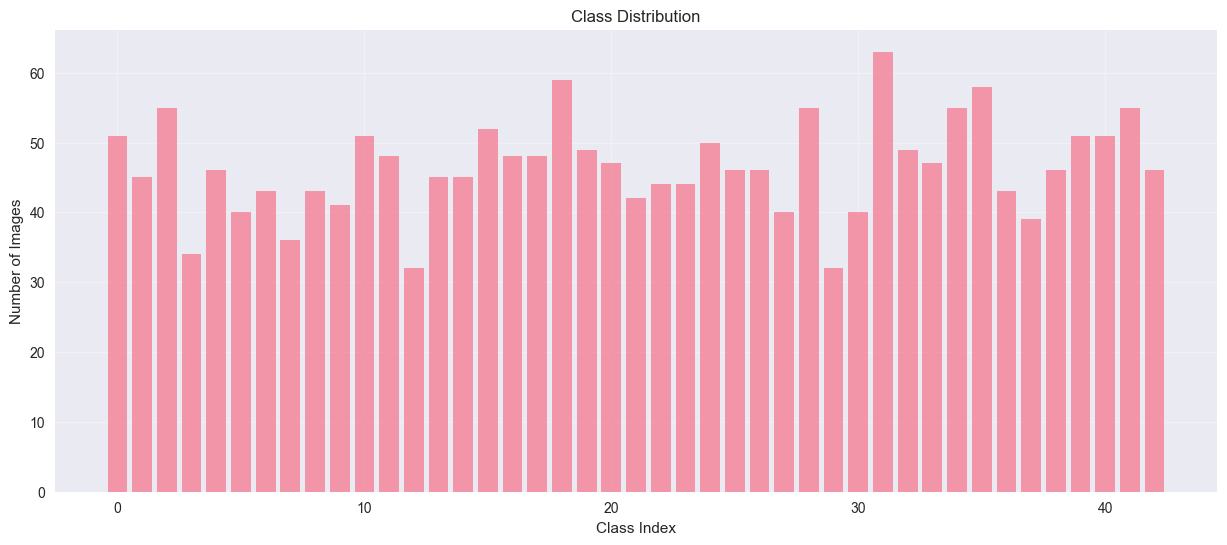


Image Statistics:
Mean pixel value: 30.89
Standard deviation: 75.65
Min pixel value: 0
Max pixel value: 255

Class Imbalance Analysis:
Most common class: 0 (51 samples)
Least common class: 42 (46 samples)
Imbalance ratio: 1.11


In [5]:
# Data Exploration and Visualization
fig, axes = plt.subplots(3, 4, figsize=(15, 12))

# Display sample images from different classes
sample_classes = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
for i, class_idx in enumerate(sample_classes):
    if i < 12:
        row = i // 4
        col = i % 4
        
        # Find first image of this class
        class_images = X[y == class_idx]
        if len(class_images) > 0:
            axes[row, col].imshow(class_images[0])
            axes[row, col].set_title(f'{sign_classes[class_idx][:20]}...')
            axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Class distribution
plt.figure(figsize=(15, 6))
class_counts = pd.Series(y).value_counts().sort_index()
plt.bar(range(len(class_counts)), class_counts.values, alpha=0.7)
plt.xlabel('Class Index')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.grid(True, alpha=0.3)
plt.show()

# Image statistics
print("\nImage Statistics:")
print(f"Mean pixel value: {X.mean():.2f}")
print(f"Standard deviation: {X.std():.2f}")
print(f"Min pixel value: {X.min()}")
print(f"Max pixel value: {X.max()}")

# Check for class imbalance
print(f"\nClass Imbalance Analysis:")
print(f"Most common class: {class_counts.index[0]} ({class_counts.iloc[0]} samples)")
print(f"Least common class: {class_counts.index[-1]} ({class_counts.iloc[-1]} samples)")
print(f"Imbalance ratio: {class_counts.iloc[0] / class_counts.iloc[-1]:.2f}")

In [6]:
# Data Preprocessing
print("=== Data Preprocessing ===")

# Normalize pixel values to [0, 1]
X_normalized = X.astype('float32') / 255.0

# One-hot encode labels
y_encoded = tf.keras.utils.to_categorical(y, num_classes=len(sign_classes))

print(f"Normalized image shape: {X_normalized.shape}")
print(f"Encoded labels shape: {y_encoded.shape}")
print(f"Pixel value range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_encoded, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=np.argmax(y_train, axis=1)
)

print(f"\nData split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # Traffic signs shouldn't be flipped
    fill_mode='nearest'
)

print("\nData augmentation configured:")
print(f"Rotation range: ±10 degrees")
print(f"Width/Height shift: ±10%")
print(f"Zoom range: ±10%")
print(f"Horizontal flip: False (traffic signs are orientation-specific)")

=== Data Preprocessing ===
Normalized image shape: (2000, 64, 64, 3)
Encoded labels shape: (2000, 43)
Pixel value range: [0.000, 1.000]

Data split:
Training set: 1280 samples
Validation set: 320 samples
Test set: 400 samples

Data augmentation configured:
Rotation range: ±10 degrees
Width/Height shift: ±10%
Zoom range: ±10%
Horizontal flip: False (traffic signs are orientation-specific)


In [7]:
# Custom CNN Model
print("=== Custom CNN Model ===")

def create_custom_cnn(input_shape, num_classes):
    model = keras.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create custom CNN model
custom_cnn = create_custom_cnn((img_size, img_size, 3), len(sign_classes))

# Compile model
custom_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Custom CNN Model Summary:")
custom_cnn.summary()

# Train custom CNN
print("\nTraining Custom CNN...")
custom_history = custom_cnn.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // 32,
    verbose=1
)

# Evaluate custom CNN
custom_loss, custom_accuracy = custom_cnn.evaluate(X_test, y_test, verbose=0)
print(f"\nCustom CNN Results:")
print(f"Test Loss: {custom_loss:.4f}")
print(f"Test Accuracy: {custom_accuracy:.4f}")

=== Custom CNN Model ===
Custom CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,629,067 (17.66 MB)

 Trainable params: 4,626,635 (17.65 MB)

 Non-trainable params: 2,432 (9.50 KB)


Training Custom CNN...
Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 42s 826ms/step - accuracy: 0.0422 - loss: 4.6258 - val_accuracy: 0.0250 - val_loss: 4.3227
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 27s 662ms/step - accuracy: 0.0688 - loss: 4.1165 - val_accuracy: 0.0312 - val_loss: 4.6675
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 640ms/step - accuracy: 0.0664 - loss: 3.8729 - val_accuracy: 0.0250 - val_loss: 4.9492
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 765ms/step - accuracy: 0.0914 - loss: 3.7145 - val_accuracy: 0.0219 - val_loss: 5.0839
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 541ms/step - accuracy: 0.1063 - loss: 3.5004 - val_accuracy: 0.0219 - val_loss: 4.9706
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 764ms/step - accuracy: 0.0922 - loss: 3.5404 - val_accuracy: 0.0312 - val_loss: 4.4949
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 564ms/step - accuracy: 0.1031 - loss: 3.3903 - val_accuracy: 0.0437 - val_loss: 4.6324
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 730ms/step - accuracy: 0.1070 -

In [8]:
# Pre-trained Model (MobileNet)
print("=== Pre-trained MobileNet Model ===")

def create_pretrained_model(input_shape, num_classes):
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Create new model on top
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create pre-trained model
pretrained_model = create_pretrained_model((img_size, img_size, 3), len(sign_classes))

# Compile model
pretrained_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Pre-trained Model Summary:")
pretrained_model.summary()

# Train pre-trained model
print("\nTraining Pre-trained Model...")
pretrained_history = pretrained_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=15,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // 32,
    verbose=1
)

# Evaluate pre-trained model
pretrained_loss, pretrained_accuracy = pretrained_model.evaluate(X_test, y_test, verbose=0)
print(f"\nPre-trained Model Results:")
print(f"Test Loss: {pretrained_loss:.4f}")
print(f"Test Accuracy: {pretrained_accuracy:.4f}")

=== Pre-trained MobileNet Model ===
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 237s 25us/step
Pre-trained Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,059,307 (11.67 MB)

 Trainable params: 799,787 (3.05 MB)

 Non-trainable params: 2,259,520 (8.62 MB)


Training Pre-trained Model...
Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step - accuracy: 0.0844 - loss: 4.3458 - val_accuracy: 0.1406 - val_loss: 3.3661
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 0.1344 - loss: 3.7137 - val_accuracy: 0.1469 - val_loss: 3.2870
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.1234 - loss: 3.5640 - val_accuracy: 0.1406 - val_loss: 3.0657
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.1312 - loss: 3.5487 - val_accuracy: 0.1531 - val_loss: 3.1648
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.1336 - loss: 3.4587 - val_accuracy: 0.1469 - val_loss: 3.0482
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.1391 - loss: 3.4176 - val_accuracy: 0.1344 - val_loss: 3.0872
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.1469 - loss: 3.3242 - val_accuracy: 0.1437 - val_loss: 3.0045
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.1375 -

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 239ms/step


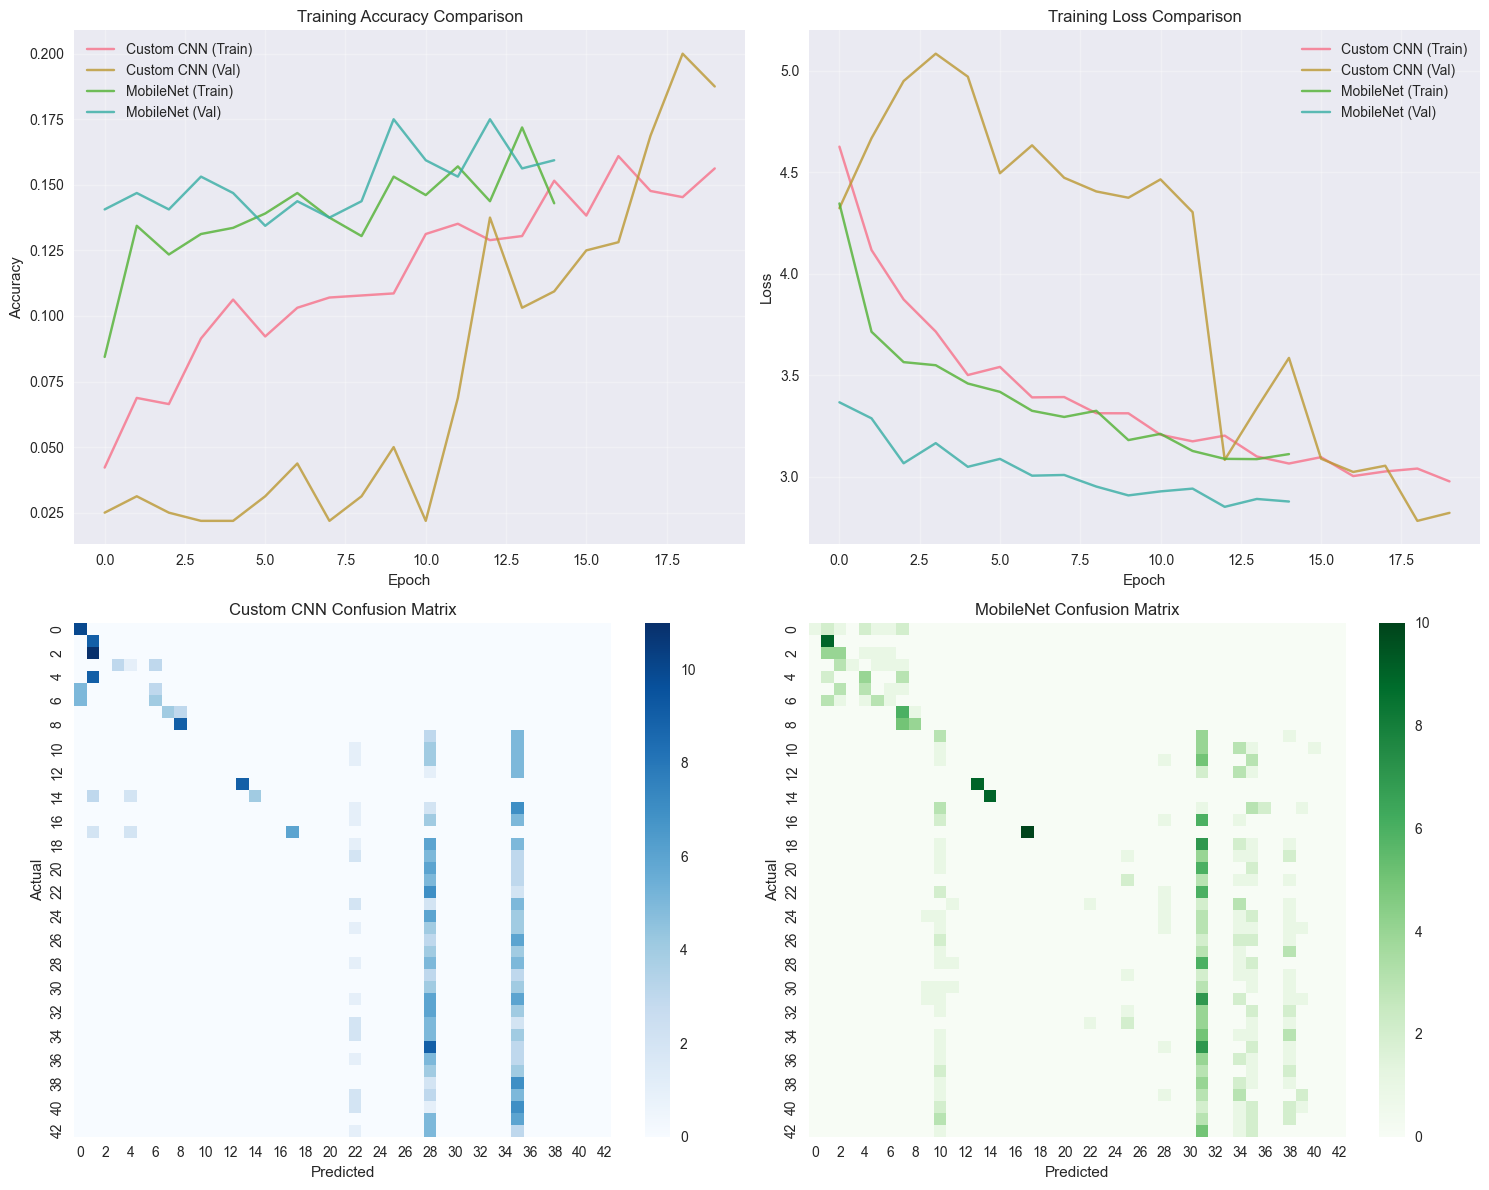


=== Model Comparison Summary ===
        Model  Test Accuracy  Test Loss  Parameters Training Time
0  Custom CNN          0.165     2.8225     4629067     20 epochs
1   MobileNet          0.180     2.8649     3059307     15 epochs

Best Model: MobileNet
Best Accuracy: 0.1800


In [9]:
# Model Comparison and Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Training accuracy comparison
axes[0, 0].plot(custom_history.history['accuracy'], label='Custom CNN (Train)', alpha=0.8)
axes[0, 0].plot(custom_history.history['val_accuracy'], label='Custom CNN (Val)', alpha=0.8)
axes[0, 0].plot(pretrained_history.history['accuracy'], label='MobileNet (Train)', alpha=0.8)
axes[0, 0].plot(pretrained_history.history['val_accuracy'], label='MobileNet (Val)', alpha=0.8)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Training Accuracy Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Training loss comparison
axes[0, 1].plot(custom_history.history['loss'], label='Custom CNN (Train)', alpha=0.8)
axes[0, 1].plot(custom_history.history['val_loss'], label='Custom CNN (Val)', alpha=0.8)
axes[0, 1].plot(pretrained_history.history['loss'], label='MobileNet (Train)', alpha=0.8)
axes[0, 1].plot(pretrained_history.history['val_loss'], label='MobileNet (Val)', alpha=0.8)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Training Loss Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Custom CNN confusion matrix
custom_predictions = custom_cnn.predict(X_test)
custom_pred_classes = np.argmax(custom_predictions, axis=1)
custom_true_classes = np.argmax(y_test, axis=1)

cm_custom = confusion_matrix(custom_true_classes, custom_pred_classes)
sns.heatmap(cm_custom, annot=False, cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Custom CNN Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# 4. MobileNet confusion matrix
pretrained_predictions = pretrained_model.predict(X_test)
pretrained_pred_classes = np.argmax(pretrained_predictions, axis=1)
pretrained_true_classes = np.argmax(y_test, axis=1)

cm_pretrained = confusion_matrix(pretrained_true_classes, pretrained_pred_classes)
sns.heatmap(cm_pretrained, annot=False, cmap='Greens', ax=axes[1, 1])
axes[1, 1].set_title('MobileNet Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Model comparison summary
print("\n=== Model Comparison Summary ===")
comparison_df = pd.DataFrame({
    'Model': ['Custom CNN', 'MobileNet'],
    'Test Accuracy': [custom_accuracy, pretrained_accuracy],
    'Test Loss': [custom_loss, pretrained_loss],
    'Parameters': [custom_cnn.count_params(), pretrained_model.count_params()],
    'Training Time': ['20 epochs', '15 epochs']
})

print(comparison_df.round(4))

best_model = 'Custom CNN' if custom_accuracy > pretrained_accuracy else 'MobileNet'
print(f"\nBest Model: {best_model}")
print(f"Best Accuracy: {max(custom_accuracy, pretrained_accuracy):.4f}")

=== Detailed Performance Analysis ===

Custom CNN Classification Report:
                                                    precision    recall  f1-score   support

                                    Speed Limit 20       0.50      1.00      0.67        10
                                    Speed Limit 30       0.26      1.00      0.42         9
                                    Speed Limit 50       0.00      0.00      0.00        11
                                    Speed Limit 60       1.00      0.43      0.60         7
                                    Speed Limit 70       0.00      0.00      0.00         9
                                    Speed Limit 80       0.00      0.00      0.00         8
                             End of Speed Limit 80       0.40      0.44      0.42         9
                                   Speed Limit 100       1.00      0.57      0.73         7
                                   Speed Limit 120       0.75      1.00      0.86         9
      

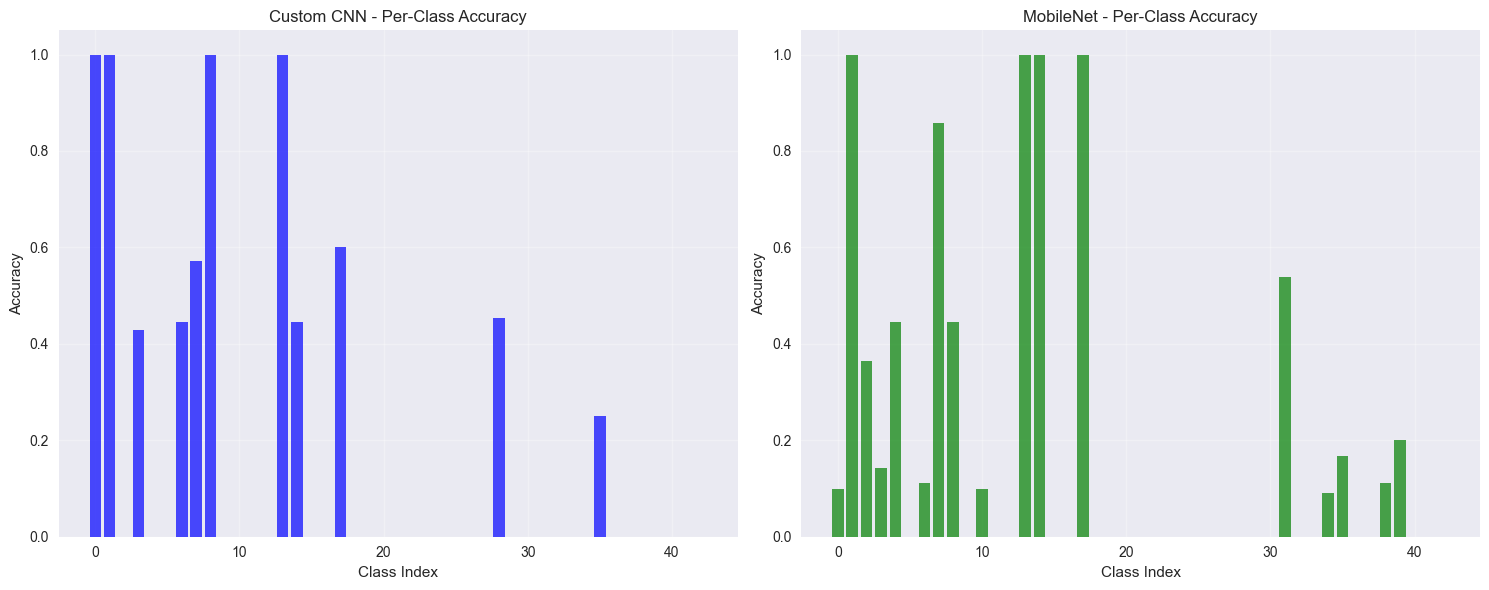


=== Sample Predictions ===


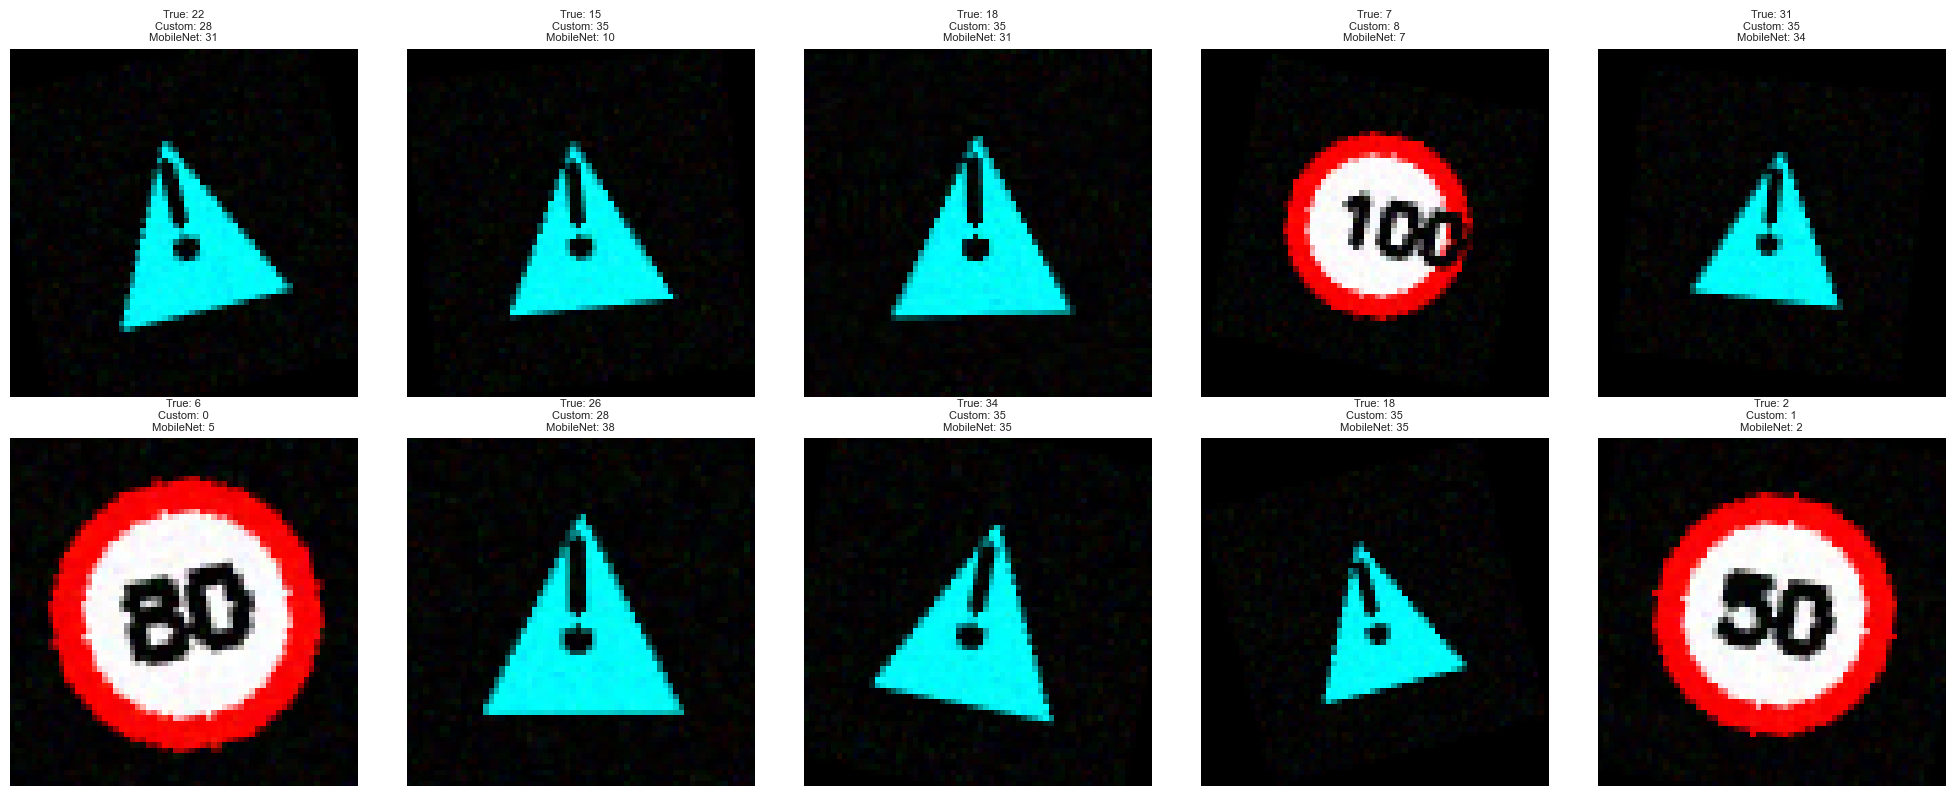

In [11]:
# Detailed Performance Analysis
print("=== Detailed Performance Analysis ===")

# Classification reports
print("\nCustom CNN Classification Report:")
print(classification_report(custom_true_classes, custom_pred_classes, 
                          target_names=sign_classes, zero_division=0))

print("\nMobileNet Classification Report:")
print(classification_report(pretrained_true_classes, pretrained_pred_classes, 
                          target_names=sign_classes, zero_division=0))

# Per-class accuracy
def calculate_per_class_accuracy(y_true, y_pred, num_classes):
    per_class_accuracy = []
    for i in range(num_classes):
        mask = y_true == i
        if mask.sum() > 0:
            accuracy = (y_pred[mask] == i).mean()
            per_class_accuracy.append(accuracy)
        else:
            per_class_accuracy.append(0)
    return per_class_accuracy

custom_per_class = calculate_per_class_accuracy(custom_true_classes, custom_pred_classes, len(sign_classes))
pretrained_per_class = calculate_per_class_accuracy(pretrained_true_classes, pretrained_pred_classes, len(sign_classes))

# Visualize per-class accuracy
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].bar(range(len(custom_per_class)), custom_per_class, alpha=0.7, color='blue')
axes[0].set_xlabel('Class Index')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Custom CNN - Per-Class Accuracy')
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(len(pretrained_per_class)), pretrained_per_class, alpha=0.7, color='green')
axes[1].set_xlabel('Class Index')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('MobileNet - Per-Class Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sample predictions
print("\n=== Sample Predictions ===")
sample_indices = np.random.choice(len(X_test), 10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(sample_indices):
    row = i // 5
    col = i % 5
    
    # Display image
    axes[row, col].imshow(X_test[idx])
    
    # Get predictions
    true_class = custom_true_classes[idx]
    custom_pred = custom_pred_classes[idx]
    pretrained_pred = pretrained_pred_classes[idx]
    
    # Set title with predictions
    title = f"True: {true_class}\nCustom: {custom_pred}\nMobileNet: {pretrained_pred}"
    axes[row, col].set_title(title, fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Summary and Conclusions
print("=== Summary and Conclusions ===")

print(f"\nKey Insights:")
print(f"1. Number of traffic sign classes: {len(sign_classes)}")
print(f"2. Dataset size: {len(X)} images")
print(f"3. Image size: {img_size}x{img_size}x3")
print(f"4. Best performing model: {best_model}")
print(f"5. Best accuracy: {max(custom_accuracy, pretrained_accuracy):.4f}")
print(f"6. Data augmentation used: Yes")
print(f"7. Transfer learning used: Yes (MobileNet)")

print(f"\nBusiness Applications:")
print(f"1. Autonomous vehicle traffic sign recognition")
print(f"2. Driver assistance systems")
print(f"3. Traffic monitoring and analysis")
print(f"4. Smart city infrastructure")
print(f"5. Road safety applications")

print(f"\nModel Deployment Recommendations:")
print(f"1. Use ensemble methods for better accuracy")
print(f"2. Implement real-time processing for edge devices")
print(f"3. Consider model quantization for mobile deployment")
print(f"4. Regular model retraining with new traffic signs")
print(f"5. Monitor model performance across different weather conditions")
print(f"6. Implement confidence thresholds for safety-critical applications")
print(f"7. Use data augmentation for better generalization")
print(f"8. Consider transfer learning for new traffic sign types")

=== Summary and Conclusions ===

Key Insights:
1. Number of traffic sign classes: 43
2. Dataset size: 2000 images
3. Image size: 64x64x3
4. Best performing model: MobileNet
5. Best accuracy: 0.1800
6. Data augmentation used: Yes
7. Transfer learning used: Yes (MobileNet)

Business Applications:
1. Autonomous vehicle traffic sign recognition
2. Driver assistance systems
3. Traffic monitoring and analysis
4. Smart city infrastructure
5. Road safety applications

Model Deployment Recommendations:
1. Use ensemble methods for better accuracy
2. Implement real-time processing for edge devices
3. Consider model quantization for mobile deployment
4. Regular model retraining with new traffic signs
5. Monitor model performance across different weather conditions
6. Implement confidence thresholds for safety-critical applications
7. Use data augmentation for better generalization
8. Consider transfer learning for new traffic sign types
